In [2]:
%matplotlib inline

import subprocess
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sb

import sqlite3
import subprocess

# Create a shell script
# with open('myscript.sh', 'w') as f:
#     f.write('cat ./database/final.sql | sqlite3 ./database/bdfinal.sql')

# Execute the script in WSL
# subprocess.run(["wsl", "./myscript.sh"], check=True,shell=True)

connection = sqlite3.connect("./database/bdfinal.sql")

In [3]:
columns = "o_fgm,o_fga,o_ftm,o_fta,o_3pm,o_3pa,o_oreb,o_dreb,o_reb,o_asts,o_pf,o_stl,o_to,o_blk,o_pts,d_fgm,d_fga,d_ftm,d_fta,d_3pm,\
    d_3pa,d_oreb,d_dreb,d_reb,d_asts,d_pf,d_stl,d_to,d_blk,d_pts,tmORB,tmDRB,tmTRB,opptmORB,opptmDRB,opptmTRB,won,lost,GP,homeW,homeL,\
    awayW,awayL,confW,confL,firstRound,semis,finals"

query_test = "SELECT playoff, seeded, " + columns + " FROM Teams WHERE year = 10"
query_train = "SELECT playoff, seeded, " + columns + " FROM Teams WHERE year <> 10"

train_data = pd.read_sql(query_train,connection)

categorical_columns = ["firstRound", "semis", "finals"]
for col in categorical_columns:
    train_data[col] = train_data[col].astype('category')

train_data= pd.get_dummies(train_data, columns=categorical_columns)
train_inputs = train_data.loc[:, train_data.columns != "playoff"].values
train_labels = train_data["playoff"].values

test_data = pd.read_sql(query_test,connection)
for col in categorical_columns:
    test_data[col] = test_data[col].astype('category')
test_data = pd.get_dummies(test_data,columns=categorical_columns)
test_inputs = test_data.loc[:, test_data.columns != "playoff"].values
test_labels = test_data["playoff"].values

print(train_data.columns[46])
# print(train_inputs)
# print(train_labels)
# print(test_inputs)
# print(test_labels)


confL


1.0


[Text(0.5, 0.75, 'x[46] <= 0.5\ngini = 0.493\nsamples = 129\nvalue = [57, 72]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 72\nvalue = [0, 72]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 57\nvalue = [57, 0]')]

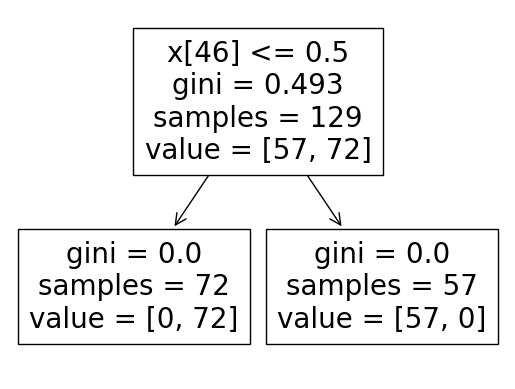

In [212]:
clf = DecisionTreeClassifier(random_state=1)
clf.fit(train_inputs,train_labels)
print(clf.score(test_inputs,test_labels))
tree.plot_tree(clf)

In [64]:
print("\n=========================================\n")

df = pd.read_sql("SELECT * FROM coaches;",connection)

null_mask = df.isnull().any(axis=1)
null_rows = df[null_mask]
print(null_rows)

print("\n=========================================\n")

df = pd.read_sql("SELECT * FROM players;",connection)

null_mask = df.isnull().any(axis=1)
null_rows = df[null_mask]
print(null_rows)

## ---//---

## get rows where pos = ""
df = pd.read_sql("SELECT * FROM players;",connection)

## iterate through rows

col_names = df.columns
for index, row in df.iterrows():
    
    ## iterate through columns
    found = False
    if row["pos"] == "":
        found = True
    elif row["height"] == 0:
        found = True
    elif row["weight"] == 0:
        found = True
    elif row["birthDate"] == "" or row["birthDate"] == "0000-00-00":
        found = True
    elif row["college"] == "":
        found = True

    if(found):
        print(row["bioID"])
    
print("\n=========================================\n")

df = pd.read_sql("SELECT * FROM players_teams;",connection)

null_mask = df.isnull().any(axis=1)
null_rows = df[null_mask]
print(null_rows)

print("\n=========================================\n")

df = pd.read_sql("SELECT * FROM series_post;",connection)

null_mask = df.isnull().any(axis=1)
null_rows = df[null_mask]
print(null_rows)

print("\n=========================================\n")

df = pd.read_sql("SELECT * FROM teams;",connection)

null_mask = df.isnull().any(axis=1)
null_rows = df[null_mask]
print(null_rows)

print("\n=========================================\n")

df = pd.read_sql("SELECT * FROM teams_post;",connection)

null_mask = df.isnull().any(axis=1)
null_rows = df[null_mask]
print(null_rows)



Empty DataFrame
Columns: [coachID, year, tmID, stint, won, lost, post_wins, post_losses]
Index: []


Empty DataFrame
Columns: [bioID, pos, height, weight, college, collegeOther, birthDate, deathDate]
Index: []
adamsmi01w
adubari99w
aglerbr99w
allenso99w
amachma01w
batkosu01w
beckan99wc
beviltu01w
bibbyhe01w
bibbyje01w
bibrzag01w
bishoab01w
bjedoni01w
boguemu01w
bonfisu01w
bouchke01w
boydca01w
boyerli99w
brancli01w
brogami01w
brownde01w
brucegr99w
bryanjo01w
burgean01w
castriz01w
chancva99w
chatmda99w
cleamji01w
coopemi01w
cowenda01w
coylepa99w
dailesh99w
darscna99w
desouer01w
donovan99w
dossaci01w
dunnli99wc
dunntr01wc
dydekma01w
estessh99w
fallotr01w
feifesu01w
fernama01w
ferrama01w
fortnne99w
fostecl99w
frankba01w
frohlli01w
gaineco01w
garcibe01w
gomisem01w
grafca99wc
grginve01w
grubigo01w
grudasa01w
hagiwmi01w
hamzoro01w
hargrli99w
harrokr01w
harveca99w
hillmli99w
hillmna01w
holdeta99w
hugheda99w
hullaja99w
jacksla01w
jekaban01w
jenkica99w
joneskc01w
kenlaje99w
keyst99wc
kingija01

## Missing Values

### Player

- After a quick glance at the data, it's easy to see that there's a certain amount of players that have many important missing/null values (college, height and weight).

In [65]:
dataframe = pd.read_sql("select bioID from players where weight = 0 or height = 0 or college = '' or pos = '';", connection)
print(dataframe)

          bioID
0    adamsmi01w
1    adubari99w
2    aglerbr99w
3    allenso99w
4    amachma01w
..          ...
163  zakalok01w
164   zarafr01w
165  zhengha01w
166  zierddo99w
167  zirkozu01w

[168 rows x 1 columns]


- From these 208 players, it's important to see which actually were a part of a team

In [66]:
active_missing_values_players = pd.read_sql("select distinct(bioID), weight, height, pos from players where (weight = 0 or height = 0) and pos <> ''", connection)
print(active_missing_values_players)

Empty DataFrame
Columns: [bioID, weight, height, pos]
Index: []


- Regarding these 83 players, if a player doesn't have their position missing, we decided to replace their missing weight and/or height values with the average value of the players of their same position. 

    - Obtain the average weight and height for each player position:

In [67]:
# query para cada valor
avg_pos_weights = pd.read_sql("select pos, avg(weight) from players where weight <> 0 group by pos;", connection)
print(avg_pos_weights)
avg_pos_heights = pd.read_sql("select pos, avg(height) from players where height <> 0 group by pos;", connection)
print(avg_pos_heights)

   pos  avg(weight)
0    C   196.975000
1  C-F   191.111111
2    F   174.018265
3  F-C   184.800000
4  F-G   159.909091
5    G   148.046823
6  G-F   163.764706
   pos  avg(height)
0    C    75.707692
1  C-F    75.333333
2    F    73.397380
3  F-C    75.188406
4  F-G    71.916667
5    G    68.540453
6  G-F    71.527273



- Store the values in two dictionaries, where the key values are the players' positions

In [68]:
# add to a dictionary where the key are the positions and the values are the avg weights
avg_weights = {}

for index, row in avg_pos_weights.iterrows():
    avg_weights[row["pos"]] = row["avg(weight)"]
    
print(avg_weights)

avg_heights = {}

for index, row in avg_pos_heights.iterrows():
    avg_heights[row["pos"]] = row["avg(height)"]
    
print(avg_heights)

{'C': 196.97499999999994, 'C-F': 191.11111111111111, 'F': 174.01826484018264, 'F-C': 184.8, 'F-G': 159.9090909090909, 'G': 148.04682274247492, 'G-F': 163.76470588235296}
{'C': 75.70769230769231, 'C-F': 75.33333333333333, 'F': 73.39737991266375, 'F-C': 75.18840579710145, 'F-G': 71.91666666666667, 'G': 68.54045307443366, 'G-F': 71.52727272727273}


In [69]:

for index, row in active_missing_values_players.iterrows():
    player = pd.read_sql("select * from players where bioID = '" + row["bioID"] + "';", connection)
    
    pos = player["pos"].values[0]
    if pos == '':
        continue
    
    if(player["weight"].values[0] != 0 and player["height"].values[0] != 0):
        # print("Player already has values")
        # print(player)
        continue
    
    print(player)
    
    print("\n===\n")

    ## get average values for the player's position pos
    if(player["weight"].values[0] == 0):
        weight = avg_weights[pos]
    else:
        weight = player["weight"].values[0]
    if (player["height"].values[0] == 0):
        height = avg_heights[pos]
    else:
        height = player["height"].values[0]

    
    
    ## get row index
    pos = row.index[0]
    
    # update player's height and weight
    print("UPDATE players SET height = '" + str(height) + "', weight = '" + str(weight) + "' WHERE bioID = '" + player["bioID"].values[0] + "';")
    
    # update player's height and weight
    connection.execute("UPDATE players SET height = " + str(height) + ", weight = " + str(weight) + " WHERE bioID = '" + player["bioID"].values[0] + "';")
    connection.commit()
    

## Inconsistent data

### Player Awards

- Check if there's any award, that should be given to one player, is given to two or more players.

In [10]:
dataframe = pd.read_sql(" select count(playerID), award, year from awards_players group by award, year;", connection)

# print rows 
print(dataframe)

    count(playerID)                               award  year
0                 1  All-Star Game Most Valuable Player     1
1                 1  All-Star Game Most Valuable Player     2
2                 1  All-Star Game Most Valuable Player     3
3                 1  All-Star Game Most Valuable Player     4
4                 1  All-Star Game Most Valuable Player     6
..              ...                                 ...   ...
76                1    WNBA Finals Most Valuable Player     6
77                1    WNBA Finals Most Valuable Player     7
78                1    WNBA Finals Most Valuable Player     8
79                1    WNBA Finals Most Valuable Player     9
80                1    WNBA Finals Most Valuable Player    10

[81 rows x 3 columns]


However, we noticed that there's an award missing part of its title. Therefore, we'll have to fix it.

In [11]:
connection.execute("UPDATE awards_players SET award = 'Kim Perrot Sportsmanship Award' WHERE award = 'Kim Perrot Sportsmanship';")
connection.commit()

### Teams Post

- Check if, in any year, no more than 8 teams passed to the playoffs.

In [12]:
dataframe = pd.read_sql("select count(tmID) as num, year from teams_post group by year having num > 8;", connection)
print(dataframe)

Empty DataFrame
Columns: [num, year]
Index: []


- Check if, in any year, only one team won the playoff.

In [13]:
dataframe = pd.read_sql("select year, tmID, finals from teams where finals = 'W' order by year;", connection)
print(dataframe)

    year tmID finals
0      1  HOU      W
1      2  LAS      W
2      3  LAS      W
3      4  DET      W
4      5  SEA      W
5      6  CON      W
6      6  SAC      W
7      7  DET      W
8      8  PHO      W
9      9  DET      W
10    10  PHO      W


### Teams

- Check if the sum of games won and lost by a player is equal to the total games played by a team

In [14]:
dataframe = pd.read_sql("select year, tmID, won, lost, GP, (won + lost) as Games from teams where Games <> GP;", connection)
print(dataframe)

Empty DataFrame
Columns: [year, tmID, won, lost, GP, Games]
Index: []


- Check if the sum of rebounds made by a team is equal to the sum of offensive rebounds and defensive rebounds

In [15]:
dataFrame = pd.read_sql("select year, tmID, o_oreb, o_dreb, o_reb, (o_oreb + o_dreb) as rebounds from teams where o_reb <> rebounds;", connection)
print(dataFrame)
print("===============================")

dataFrame = pd.read_sql("select year, tmID, d_oreb, d_dreb, d_reb, (d_oreb + d_dreb) as rebounds from teams where d_reb <> rebounds;", connection)
print(dataFrame)

Empty DataFrame
Columns: [year, tmID, o_oreb, o_dreb, o_reb, rebounds]
Index: []
Empty DataFrame
Columns: [year, tmID, d_oreb, d_dreb, d_reb, rebounds]
Index: []


- Check if the stats (field goals, 3 pointers, free throws, etc.) attempted are in a bigger quantity than the stats made

In [16]:
dataframe = pd.read_sql("select year, tmID from teams where o_fgm > o_fga;", connection)
print(dataframe)
print("===============================")

dataframe = pd.read_sql("select year, tmID from teams where o_ftm > o_fta;", connection)
print(dataframe)
print("===============================")

dataframe = pd.read_sql("select year, tmID from teams where o_3pm > o_3pa;", connection)
print(dataframe)
print("===============================")

dataframe = pd.read_sql("select year, tmID from teams where d_fgm > d_fga;", connection)
print(dataframe)
print("===============================")

dataframe = pd.read_sql("select year, tmID from teams where d_ftm > d_fta;", connection)
print(dataframe)
print("===============================")

dataframe = pd.read_sql("select year, tmID from teams where d_3pm > d_3pa;", connection)
print(dataframe)
print("===============================")


Empty DataFrame
Columns: [year, tmID]
Index: []
Empty DataFrame
Columns: [year, tmID]
Index: []
Empty DataFrame
Columns: [year, tmID]
Index: []
Empty DataFrame
Columns: [year, tmID]
Index: []
Empty DataFrame
Columns: [year, tmID]
Index: []
Empty DataFrame
Columns: [year, tmID]
Index: []


## Removing irrelevant Columns

In [70]:
# remove tmORB, tmDRB, tmTRB, opptmORB, opptmDRB, opptmTRB from teams using a query
connection.execute("ALTER TABLE teams DROP COLUMN tmORB;")
connection.execute("ALTER TABLE teams DROP COLUMN tmDRB;")
connection.execute("ALTER TABLE teams DROP COLUMN tmTRB;")
connection.execute("ALTER TABLE teams DROP COLUMN opptmORB;")
connection.execute("ALTER TABLE teams DROP COLUMN opptmDRB;")
connection.execute("ALTER TABLE teams DROP COLUMN opptmTRB;")

# remove franchID and lgID from teams using a query
connection.execute("ALTER TABLE teams DROP COLUMN franchID;")
connection.execute("ALTER TABLE teams DROP COLUMN lgID;")

OperationalError: no such column: "tmORB"

In [71]:
# remove firstSeason and lastSeason from players using a query
connection.execute("ALTER TABLE players DROP COLUMN firstSeason;")
connection.execute("ALTER TABLE players DROP COLUMN lastSeason;")

OperationalError: no such column: "firstSeason"

In [72]:
#remove lgIDWinner, lgIDLoser and series from series_post using a query
connection.execute("ALTER TABLE series_post DROP COLUMN lgIDWinner;")
connection.execute("ALTER TABLE series_post DROP COLUMN lgIDLoser;")
connection.execute("ALTER TABLE series_post DROP COLUMN series;")

OperationalError: no such column: "lgIDWinner"

In [73]:
#remove lgID from teams_post using a query
connection.execute("ALTER TABLE teams_post DROP COLUMN lgID;")

#remove lgID from awards_players using a query
connection.execute("ALTER TABLE awards_players DROP COLUMN lgID;")

#remove lgID from players_teams using a query
connection.execute("ALTER TABLE players_teams DROP COLUMN lgID;")

OperationalError: no such column: "lgID"

In [21]:
#remove lgID from coaches using a query
connection.execute("ALTER TABLE coaches DROP COLUMN lgID;")

# Trying models

In [111]:
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LogisticRegression

# remove confID and divID from teams using a query
# connection.execute("ALTER TABLE teams DROP COLUMN confID;")
# connection.execute("ALTER TABLE teams DROP COLUMN divID;")
connection.commit()

# get data
df = pd.read_sql("select * from players join players_teams on players.bioID = players_teams.playerID;", connection)

columns = ['bioID', 'pos', 'height', 'weight', 'college', 'collegeOther',
       'birthDate', 'year', 'stINTEGER', 'tmID', 'points', 'oRebounds', 'dRebounds', 'rebounds',
       'assists', 'steals', 'blocks', 'turnovers', 'PF', 'fgAttempted',
       'fgMade', 'ftAttempted', 'ftMade', 'threeAttempted', 'threeMade']

df = df[columns]

# get bioID and year from the dataframe
bioID = df["bioID"].values
year = df["year"].values

iterable = zip(bioID, year)

# iterate through the (bioID, year) pairs

for bioID, year in iterable:
        # get number of awards for the player in the team in the year
        query = "select count(award) as num_awards_player from awards_players ap join players_teams pt on ap.year = pt.year \
                and ap.playerID = pt.playerID where ap.playerID = '" + bioID + "' and ap.year <= " + str(year) + ";"
                
        player_awards = pd.read_sql(query, connection)
        
        # if(player_awards["num_awards_player"].values[0] > 0):
        #         print(bioID, year, player_awards)
                
        # add number of awards to the dataframe
        df.loc[(df["bioID"] == bioID) & (df["year"] == year), "num_awards_player"] = player_awards["num_awards_player"].values[0]
     
# extract year from birthDate
df["birthDate"] = pd.to_datetime(df["birthDate"])
df["birthDate"] = df["birthDate"].dt.year

player_ids_10 = df[df["year"] == 10]["bioID"].values

In [144]:
# transform categorical data
categorical_columns = ['bioID', 'pos', 'college', 'collegeOther', 'tmID']
for col in categorical_columns:
    df[col] = df[col].astype('category')
    
df = pd.get_dummies(df, columns=categorical_columns)

print(df['birthDate'])

# # get all rows from df where year = 10
test_data = df.loc[df["year"] == 10]

# # get all rows from df where year <> 10
train_data = df.loc[df["year"] != 10]


labels = ['points', 'oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals',
       'blocks', 'turnovers', 'PF', 'fgAttempted', 'fgMade', 'ftAttempted',
       'ftMade', 'threeAttempted', 'threeMade']

inputs = []

for col in train_data.columns:
    if col not in labels:
        inputs.append(col)

print(inputs)

train_inputs = train_data[inputs].values
train_labels = train_data[labels].values

test_inputs = test_data[inputs].values
test_labels = test_data[labels].values

# scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_inputs = scaler.fit_transform(train_inputs)
test_inputs = scaler.transform(test_inputs)

0       1980
1       1980
2       1980
3       1980
4       1980
        ... 
1871    1977
1872    1976
1873    1986
1874    1980
1875    1986
Name: birthDate, Length: 1876, dtype: int32
['height', 'weight', 'birthDate', 'year', 'stINTEGER', 'num_awards_player', 'bioID_abrossv01w', 'bioID_adamsjo01w', 'bioID_aguilel01w', 'bioID_ajavoma01w', 'bioID_aldrima01w', 'bioID_alhalta01w', 'bioID_allench01w', 'bioID_amachma01w', 'bioID_ambermo01w', 'bioID_anderam01w', 'bioID_anderch01w', 'bioID_anderjo01w', 'bioID_anderke01w', 'bioID_andrame01w', 'bioID_anosini01w', 'bioID_arcaija01w', 'bioID_askamma01w', 'bioID_atkinla01w', 'bioID_atunrmo01w', 'bioID_augusse01w', 'bioID_aycocan01w', 'bioID_azizle01w', 'bioID_azzije01w', 'bioID_badertr01w', 'bioID_bakersh01w', 'bioID_balesal01w', 'bioID_banchrh01w', 'bioID_baranel01w', 'bioID_barksla01w', 'bioID_barnead01w', 'bioID_barnequ01w', 'bioID_batkosu01w', 'bioID_batteja01w', 'bioID_battlas01w', 'bioID_bauerca01w', 'bioID_beardal01w', 'bioID_beckki01w', 

In [ ]:
# train model
model = MultiOutputRegressor(MLPRegressor(hidden_layer_sizes=(100, 100, 100), max_iter=2000,batch_size=32, alpha=0.0001, solver='adam', verbose=10, random_state=21, tol=0.000000001))
model.fit(train_inputs, train_labels)

# test model
predictions = model.predict(test_inputs)
print(predictions)

In [ ]:
# convert all predictions to integers
for i in range(len(predictions)):
    for j in range(len(predictions[i])):
        predictions[i][j] = int(round(predictions[i][j]))

for i in range(len(predictions)):
    # print("player: ", i)
    print("player: ", player_ids_10[i])
    for j in range(len(predictions[i])):
        print(labels[j], ":  predicted: ", predictions[i][j], " actual: ", test_labels[i][j])
    print("\n")


In [145]:
model = MultiOutputRegressor(LogisticRegression(solver='lbfgs', max_iter=1000))
model.fit(train_inputs, train_labels)

# test model
predictions = model.predict(test_inputs)
print(predictions)

C:\Users\Utilizador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  options={"iprint": iprint, "gtol": tol, "maxiter": max_iter},


In [112]:
# get team ids from the dataframe from all years 
team_ids = set(df["tmID"].values)
print(team_ids)

# create a dictionary where the keys are the team ids and the values are the avg stats for the team
avg_team_stats = {}

for team_id in team_ids:
    avg_team_stats[team_id] = [0] * len(labels)
    
print(test_data.columns)

# iterate through the team ids
for team_id in team_ids:
    
    for i in range(len(predictions)):
 
        if(test_data["tmID_" + team_id].values[i] == 1):
            avg_team_stats[team_id] = [x + y for x, y in zip(avg_team_stats[team_id], predictions[i])]
            
        
# remove tmID from the dictionary that contain all the avg stats for the teams at 0
for team_id in team_ids:
    if(avg_team_stats[team_id] == [0] * len(labels)):
        del avg_team_stats[team_id]
        
        
print(avg_team_stats)

{'MIN', 'CON', 'POR', 'HOU', 'IND', 'ATL', 'NYL', 'ORL', 'SAS', 'UTA', 'SEA', 'WAS', 'MIA', 'CLE', 'CHI', 'DET', 'CHA', 'LAS', 'SAC', 'PHO'}
Index(['height', 'weight', 'birthDate', 'year', 'stINTEGER', 'points',
       'oRebounds', 'dRebounds', 'rebounds', 'assists',
       ...
       'tmID_MIN', 'tmID_NYL', 'tmID_ORL', 'tmID_PHO', 'tmID_POR', 'tmID_SAC',
       'tmID_SAS', 'tmID_SEA', 'tmID_UTA', 'tmID_WAS'],
      dtype='object', length=735)
{'MIN': [2921.0, 303.0, 751.0, 971.0, 545.0, 258.0, 120.0, 426.0, 714.0, 2170.0, 812.0, 693.0, 545.0, 501.0, 218.0], 'CON': [3248.0, 408.0, 1069.0, 1377.0, 661.0, 253.0, 150.0, 578.0, 865.0, 2997.0, 1199.0, 906.0, 658.0, 811.0, 292.0], 'IND': [2709.0, 394.0, 916.0, 1049.0, 492.0, 299.0, 151.0, 564.0, 772.0, 2234.0, 976.0, 685.0, 603.0, 599.0, 179.0], 'ATL': [2914.0, 427.0, 899.0, 1242.0, 619.0, 416.0, 191.0, 650.0, 969.0, 2520.0, 1248.0, 912.0, 697.0, 788.0, 234.0], 'NYL': [2345.0, 344.0, 680.0, 966.0, 477.0, 258.0, 129.0, 411.0, 588.0, 1992.0, 9

In [113]:
query = "select * from teams;"

team_stats = pd.read_sql(query, connection)

columns = ['tmID', 'year','o_pts', 'o_oreb', 'o_dreb', 'o_reb', 'o_asts', 'o_stl',
       'o_blk', 'o_to', 'o_pf', 'o_fga', 'o_fgm', 'o_fta',
       'o_ftm', 'o_3pa', 'o_3pm', 'confID', 'playoff']

team_stats = team_stats[columns]

query = "select tmID from teams where year = 10;"
team_ids = pd.read_sql(query, connection)
team_ids = team_ids["tmID"].values

team_stats = team_stats.drop(columns=["tmID"])

categorical_columns = ['confID']

for col in categorical_columns:
       team_stats[col] = team_stats[col].astype('category')
       
team_stats = pd.get_dummies(team_stats, columns=categorical_columns)
       

In [114]:
labels = ['playoff']
inputs = []

for col in team_stats.columns:
    if col not in labels:
        inputs.append(col)

train_data = team_stats.loc[team_stats["year"] != 10]

print(train_data.columns)

test_data = team_stats.loc[team_stats["year"] == 10]

# drop year column from train and test data
train_data = train_data.drop(columns=["year"])
test_data = test_data.drop(columns=["year"])

# drop year from inputs
inputs.remove("year")

train_inputs = train_data[inputs].values
train_labels = train_data[labels].values


print("train_inputs:")
print(train_inputs)

test_inputs= []

for team_id in avg_team_stats:
    # append confID to the list
    
    query = "select confID from teams where tmID = '" + team_id + "';"
    confID = pd.read_sql(query, connection)
    confID = confID["confID"].values[0]
    
    avg_team_stats[team_id].append(confID == 'EA')
    avg_team_stats[team_id].append(confID == 'WE')
    
    test_inputs.append(avg_team_stats[team_id])
    
    
test_labels = test_data[labels].values

# print(train_inputs)
# print(train_labels)

print(test_inputs)
print(test_labels)

Index(['year', 'o_pts', 'o_oreb', 'o_dreb', 'o_reb', 'o_asts', 'o_stl',
       'o_blk', 'o_to', 'o_pf', 'o_fga', 'o_fgm', 'o_fta', 'o_ftm', 'o_3pa',
       'o_3pm', 'playoff', 'confID_EA', 'confID_WE'],
      dtype='object')
train_inputs:
[[2534 340 737 ... 202 True False]
 [2186 305 630 ... 131 True False]
 [2055 309 639 ... 153 True False]
 ...
 [2747 330 770 ... 187 True False]
 [2585 335 783 ... 163 True False]
 [2368 362 770 ... 163 True False]]
[[2921.0, 303.0, 751.0, 971.0, 545.0, 258.0, 120.0, 426.0, 714.0, 2170.0, 812.0, 693.0, 545.0, 501.0, 218.0, False, True], [3248.0, 408.0, 1069.0, 1377.0, 661.0, 253.0, 150.0, 578.0, 865.0, 2997.0, 1199.0, 906.0, 658.0, 811.0, 292.0, True, False], [2709.0, 394.0, 916.0, 1049.0, 492.0, 299.0, 151.0, 564.0, 772.0, 2234.0, 976.0, 685.0, 603.0, 599.0, 179.0, True, False], [2914.0, 427.0, 899.0, 1242.0, 619.0, 416.0, 191.0, 650.0, 969.0, 2520.0, 1248.0, 912.0, 697.0, 788.0, 234.0, True, False], [2345.0, 344.0, 680.0, 966.0, 477.0, 258.0, 129.0,

## Logistic Regression

C:\Users\Utilizador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  f"{estimator_name} requires y to be passed, but the target y is None"


Accuracy: 0.5384615384615384
Precision: 0.6666666666666666
Recall: 0.5
F1: 0.5714285714285715
Confusion matrix:
[[3 2]
 [4 4]]


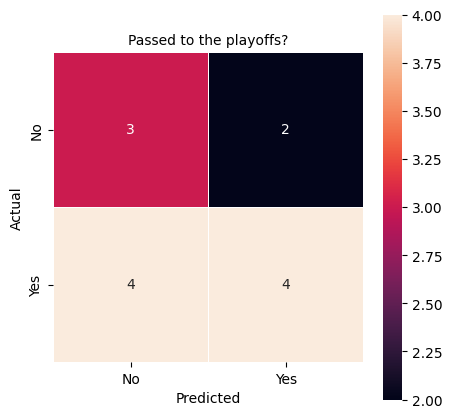

[('SAC', 0.9999846641947634), ('MIN', 0.9481450750158734), ('LAS', 0.8783739759069118), ('PHO', 0.7757236827048104), ('SAS', 0.009719329090717843), ('SEA', 8.660742583303479e-06)]
[('ATL', 0.9539704812494335), ('IND', 0.598078959513086), ('CON', 0.3615412463217238), ('DET', 0.3017595274714811), ('WAS', 0.22384675824418068), ('NYL', 8.986019655412926e-06), ('CHI', 2.517230383788073e-06)]


In [118]:
# logistic regression
from sklearn.metrics import confusion_matrix

logreg = LogisticRegression(max_iter=1000)
logreg.fit(train_inputs,train_labels)

y_pred = logreg.predict(test_inputs)
#print metrics
print("Accuracy:",metrics.accuracy_score(test_labels,y_pred))
print("Precision:",metrics.precision_score(test_labels, y_pred, pos_label="Y"))
print("Recall:",metrics.recall_score(test_labels, y_pred, pos_label="Y"))
print("F1:",metrics.f1_score(test_labels, y_pred, pos_label="Y"))

# confusion matrix
confusion = confusion_matrix(test_labels, y_pred)
print(f"Confusion matrix:\n{confusion}")

#plot confusion matrix
plt.figure(figsize=(5,5))
sb.heatmap(confusion, annot=True, fmt="g", linewidths=.5, square = True, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
all_sample_title = 'Passed to the playoffs?'
plt.title(all_sample_title, size = 10)
plt.show()

query = "select tmId, confID from teams where year = 10;"
teams_conf_ids = pd.read_sql(query, connection)

query = "select tmID from teams where year = 10;"

# print(teams_conf_ids)

west_teams = teams_conf_ids[teams_conf_ids["confID"] == "WE"]
east_teams = teams_conf_ids[teams_conf_ids["confID"] == "EA"]

# print(west_teams)
# print(east_teams)

# print the probabilities for each class
probs = logreg.predict_proba(test_inputs)
probs_west = []
probs_east = []

for i in range(len(probs)):
    team_id = team_ids[i]
    
    if team_id in west_teams["tmID"].values:
        probs_west.append((team_id, probs[i][1]))
        
    if team_id in east_teams["tmID"].values:
        probs_east.append((team_id, probs[i][1]))
    
    # print(f"{team_name[0]}: {probs[i][1]}")

probs_west = sorted(probs_west, key=lambda x: x[1], reverse=True)
probs_east = sorted(probs_east, key=lambda x: x[1], reverse=True)

print(probs_west)
print(probs_east)

## Neural Network

C:\Users\Utilizador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  dtype=(np.float64, np.float32),


Accuracy: 0.5384615384615384
Precision: 0.625
Recall: 0.625
F1: 0.625
Confusion matrix:
[[2 3]
 [3 5]]


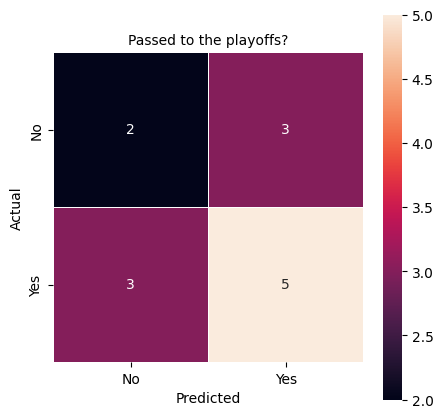

[('SAC', 0.9999999190479677), ('SAS', 0.9990083292989453), ('MIN', 0.9982886693117763), ('LAS', 0.9703256823963834), ('PHO', 0.8399540159066804), ('SEA', 0.0004674622153275168)]
[('WAS', 0.9996310523285029), ('IND', 0.9976067904124346), ('CON', 0.7878523453548948), ('DET', 0.004070366181996974), ('ATL', 0.0016354715374267792), ('CHI', 5.443572466044532e-06), ('NYL', 3.384856596635095e-12)]


In [119]:
# neural network

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=1000, alpha=0.0001, solver='adam', verbose=0, random_state=21, tol=0.000000001)
mlp.fit(train_inputs,train_labels)

y_pred = mlp.predict(test_inputs)
#print metrics
print("Accuracy:",metrics.accuracy_score(test_labels,y_pred))
print("Precision:",metrics.precision_score(test_labels, y_pred, pos_label="Y"))

print("Recall:",metrics.recall_score(test_labels, y_pred, pos_label="Y"))
print("F1:",metrics.f1_score(test_labels, y_pred, pos_label="Y"))

# confusion matrix
confusion = confusion_matrix(test_labels, y_pred)
print(f"Confusion matrix:\n{confusion}")

#plot confusion matrix
plt.figure(figsize=(5,5))
sb.heatmap(confusion, annot=True, fmt="g", linewidths=.5, square = True, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
all_sample_title = 'Passed to the playoffs?'
plt.title(all_sample_title, size = 10)
plt.show()

# print the probabilities for each class
probs = mlp.predict_proba(test_inputs)
probs_west = []
probs_east = []

for i in range(len(probs)):
    team_id = team_ids[i]
    
    if team_id in west_teams["tmID"].values:
        probs_west.append((team_id, probs[i][1]))
        
    if team_id in east_teams["tmID"].values:
        probs_east.append((team_id, probs[i][1]))
    
    # print(f"{team_name[0]}: {probs[i][1]}")
    
probs_west = sorted(probs_west, key=lambda x: x[1], reverse=True)
probs_east = sorted(probs_east, key=lambda x: x[1], reverse=True)

print(probs_west)
print(probs_east)


## Support Vector Machine (SVM)

C:\Users\Utilizador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  f"{estimator_name} requires y to be passed, but the target y is None"


Accuracy: 0.6923076923076923
Precision: 0.75
Recall: 0.75
F1: 0.75
Confusion matrix:
[[3 2]
 [2 6]]


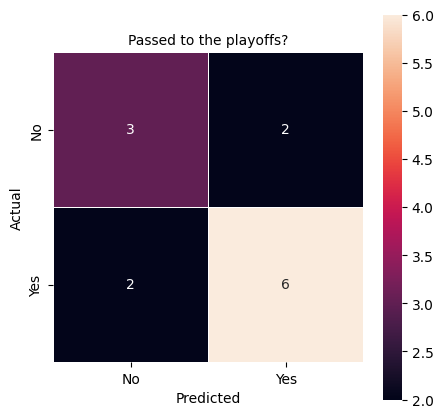

[('SAC', 0.9720001586540922), ('PHO', 0.7024213353816572), ('LAS', 0.6541643575668368), ('MIN', 0.6410978643842516), ('SAS', 0.20745300090158397), ('SEA', 0.019652642364400844)]
[('ATL', 0.7267253461676987), ('IND', 0.6997551584017581), ('WAS', 0.6014840745745428), ('DET', 0.5727680460896472), ('CON', 0.47473556903727493), ('CHI', 0.020292428989283462), ('NYL', 0.019052455478159477)]


In [120]:
# SVM

from sklearn import svm

clf = svm.SVC(kernel='linear', C=1, probability=True)
clf.fit(train_inputs,train_labels)

y_pred = clf.predict(test_inputs)

#print metrics
print("Accuracy:",metrics.accuracy_score(test_labels,y_pred))
print("Precision:",metrics.precision_score(test_labels, y_pred, pos_label="Y"))
print("Recall:",metrics.recall_score(test_labels, y_pred, pos_label="Y"))
print("F1:",metrics.f1_score(test_labels, y_pred, pos_label="Y"))

# confusion matrix
confusion = confusion_matrix(test_labels, y_pred)
print(f"Confusion matrix:\n{confusion}")

#plot confusion matrix
plt.figure(figsize=(5,5))
sb.heatmap(confusion, annot=True, fmt="g", linewidths=.5, square = True, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
all_sample_title = 'Passed to the playoffs?'

plt.title(all_sample_title, size = 10)
plt.show()

# print the probabilities for each class
probs = clf.predict_proba(test_inputs)
probs_west = []
probs_east = []

for i in range(len(probs)):
    
    team_id = team_ids[i]
    
    if team_id in west_teams["tmID"].values:
        probs_west.append((team_id, probs[i][1]))
        
    if team_id in east_teams["tmID"].values:
        probs_east.append((team_id, probs[i][1]))
    
    # print(f"{team_name[0]}: {probs[i][1]}")
    
probs_west = sorted(probs_west, key=lambda x: x[1], reverse=True)
probs_east = sorted(probs_east, key=lambda x: x[1], reverse=True)

print(probs_west)
print(probs_east)

## K-Nearest Neighbour

C:\Users\Utilizador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  def fit(self, X, y):


Accuracy: 0.6923076923076923
Precision: 0.6666666666666666
Recall: 1.0
F1: 0.8
Confusion matrix:
[[1 4]
 [0 8]]


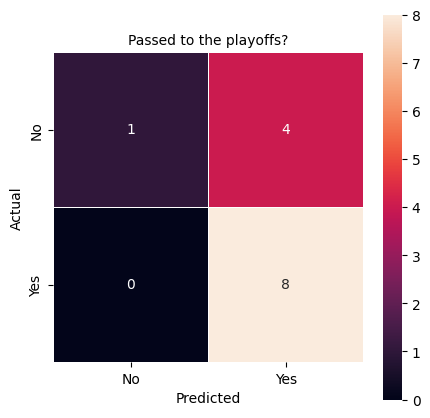

[('MIN', 0.8333333333333334), ('SAC', 0.7083333333333334), ('PHO', 0.6666666666666666), ('LAS', 0.625), ('SAS', 0.5833333333333334), ('SEA', 0.5833333333333334)]
[('CON', 0.625), ('DET', 0.625), ('ATL', 0.5833333333333334), ('CHI', 0.5833333333333334), ('WAS', 0.5833333333333334), ('IND', 0.5416666666666666), ('NYL', 0.5)]


In [132]:
# KNN

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=24)
knn.fit(train_inputs,train_labels)

y_pred = knn.predict(test_inputs)

#print metrics
print("Accuracy:",metrics.accuracy_score(test_labels,y_pred))
print("Precision:",metrics.precision_score(test_labels, y_pred, pos_label="Y"))
print("Recall:",metrics.recall_score(test_labels, y_pred, pos_label="Y"))
print("F1:",metrics.f1_score(test_labels, y_pred, pos_label="Y"))

# confusion matrix
confusion = confusion_matrix(test_labels, y_pred)
print(f"Confusion matrix:\n{confusion}")

#plot confusion matrix
plt.figure(figsize=(5,5))
sb.heatmap(confusion, annot=True, fmt="g", linewidths=.5, square = True, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
all_sample_title = 'Passed to the playoffs?'

plt.title(all_sample_title, size = 10)
plt.show()

# print the probabilities for each class
probs = knn.predict_proba(test_inputs)
probs_west = []
probs_east = []

for i in range(len(probs)):
    
    team_id = team_ids[i]
    
    if team_id in west_teams["tmID"].values:
        probs_west.append((team_id, probs[i][1]))
        
    if team_id in east_teams["tmID"].values:
        probs_east.append((team_id, probs[i][1]))
    
    # print(f"{team_name[0]}: {probs[i][1]}")
    
probs_west = sorted(probs_west, key=lambda x: x[1], reverse=True)
probs_east = sorted(probs_east, key=lambda x: x[1], reverse=True)

print(probs_west)
print(probs_east)


## Decision Tree

Accuracy: 0.6923076923076923
Precision: 0.8333333333333334
Recall: 0.625
F1: 0.7142857142857143
Confusion matrix:
[[4 1]
 [3 5]]


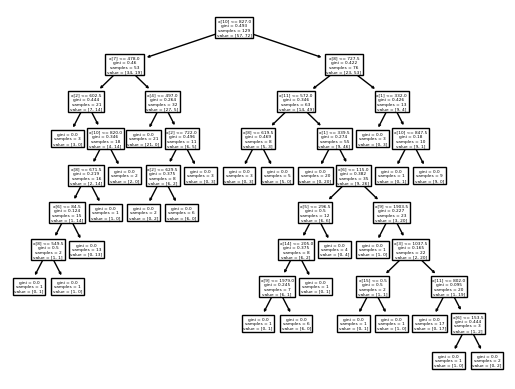

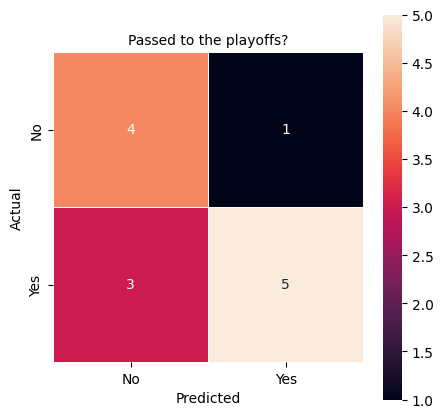

In [142]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

dt.fit(train_inputs,train_labels)

#print decision tree
tree.plot_tree(dt)

y_pred = dt.predict(test_inputs)

#print metrics
print("Accuracy:",metrics.accuracy_score(test_labels,y_pred))
print("Precision:",metrics.precision_score(test_labels, y_pred, pos_label="Y"))
print("Recall:",metrics.recall_score(test_labels, y_pred, pos_label="Y"))
print("F1:",metrics.f1_score(test_labels, y_pred, pos_label="Y"))

# confusion matrix
confusion = confusion_matrix(test_labels, y_pred)
print(f"Confusion matrix:\n{confusion}")

#plot confusion matrix
plt.figure(figsize=(5,5))
sb.heatmap(confusion, annot=True, fmt="g", linewidths=.5, square = True, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
all_sample_title = 'Passed to the playoffs?'

plt.title(all_sample_title, size = 10)
plt.show()

# print the probabilities for each class
probs = dt.predict_proba(test_inputs)
probs_west = []
probs_east = []

for i in range(len(probs)):
        
        team_id = team_ids[i]
        
        if team_id in west_teams["tmID"].values:
            probs_west.append((team_id, probs[i][1]))
            
        if team_id in east_teams["tmID"].values:
            probs_east.append((team_id, probs[i][1]))
        
        # print(f"{team_name[0]}: {probs[i][1]}")
        
probs_west = sorted(probs_west, key=lambda x: x[1], reverse=True)
probs_east = sorted(probs_east, key=lambda x: x[1], reverse=True)


In [ ]:
# import precision_score, recall_score, f1_score
from sklearn.metrics import precision_score, recall_score, f1_score

# get accuracy, precision, recall, f1-score
for i in range(test_labels.shape[1]):
    print("label: ", labels[i])
    print("accuracy: ", accuracy_score(test_labels[:,i], predictions[:,i]))
    print("precision: ", precision_score(test_labels[:,i], predictions[:,i], average='weighted'))
    print("recall: ", recall_score(test_labels[:,i], predictions[:,i], average='weighted'))
    print("f1-score: ", f1_score(test_labels[:,i], predictions[:,i], average='weighted'))
    print("\n")

In [30]:
# try neuronal model 
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# remove confID and divID from teams using a query
connection.execute("ALTER TABLE teams DROP COLUMN confID;")
connection.execute("ALTER TABLE teams DROP COLUMN divID;")
connection.commit()

# get data
df = pd.read_sql("select * from teams;", connection)
print(df.columns)

# transform categorical data
categorical_columns = ["tmID", "firstRound", "semis", "finals","name","arena"]
for col in categorical_columns:
    df[col] = df[col].astype('category')
    
df = pd.get_dummies(df, columns=categorical_columns)

print(df.columns)

# get inputs and outputs
inputs = df.loc[:, df.columns != "playoff"].values
labels = df["playoff"].values

# split data
train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs, labels, test_size=0.3, random_state=1)

# scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_inputs = scaler.fit_transform(train_inputs)
test_inputs = scaler.transform(test_inputs)

# create model
model = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=2000,batch_size=32, alpha=0.0001, solver='adam', verbose=10, random_state=21, tol=0.000000001)
model.fit(train_inputs, train_labels)

# predict
predictions = model.predict(test_inputs)

# print results
print("Accuracy:", accuracy_score(test_labels, predictions))
print("Confusion Matrix:\n", confusion_matrix(test_labels, predictions))
print("Classification Report:\n", classification_report(test_labels, predictions))


Index(['year', 'tmID', 'rank', 'playoff', 'seeded', 'o_fgm', 'o_fga', 'o_ftm',
       'o_fta', 'o_3pm', 'o_3pa', 'o_oreb', 'o_dreb', 'o_reb', 'o_asts',
       'o_pf', 'o_stl', 'o_to', 'o_blk', 'o_pts', 'd_fgm', 'd_fga', 'd_ftm',
       'd_fta', 'd_3pm', 'd_3pa', 'd_oreb', 'd_dreb', 'd_reb', 'd_asts',
       'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts', 'won', 'lost', 'GP', 'homeW',
       'homeL', 'awayW', 'awayL', 'confW', 'confL', 'min', 'attend'],
      dtype='object')


ValueError: X has 2 features, but MLPClassifier is expecting 64 features as input.